In [14]:
import csv
import os
import random
import logging 
import umap

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import scipy.spatial as ss
import matplotlib.pylab as plt

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarDiGraph, StellarGraph
from sklearn.manifold import TSNE

In [15]:
import imp
from cell import plot_utils, graph_utils, analysis, utils, math_utils, word2vec_utils
import cell.BiasedDirectedWeightedWalk as BDWW

imp.reload(plot_utils)
imp.reload(graph_utils)
imp.reload(analysis)
imp.reload(utils)
imp.reload(math_utils)
imp.reload(umap)


<module 'umap' from '/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/umap/__init__.py'>

#### Read ref cldf

In [16]:
cldf = utils.read_visp_npp_cldf()
cldf.head()

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


,dendcluster_id,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color
cluster_id,,,,,,,,,,
0,1,L2/3 IT VISp Rrad,#D9F077,#D9F077,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1
1,2,L2/3 IT VISp Adamts2,#A6E6A9,#A6E6A9,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1
2,3,L2/3 IT VISp Agmat,#7AE6AB,#7AE6AB,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1
3,7,L4 IT VISp Rspo1,#00979D,#00979D,8,L4,#00979D,2,Glutamatergic,#27AAE1
4,8,L5 IT VISp Hsd11b1 Endou,#00DDC5,#00DDC5,9,L5 IT,#008A61,2,Glutamatergic,#27AAE1


In [27]:
index_and_cols_names = cldf.cluster_label.values.tolist()

In [28]:
layers = utils.get_npp_visp_layers()
layers[0:5]

listing from: //Users/fahimehb/Documents/NPP_GNN_project/dat/graphs/VISp


['Nts-Ntsr2', 'Nmb-Nmbr', 'Pdyn-Oprk1', 'Tac2-Tacr3', 'Npy-Npy1r']

### Add all layers

In [29]:
total_inter = np.zeros((93,93))

for layer in layers:
    path = utils.get_npp_visp_interaction_mat_path(layer)
    tmp_inter= pd.read_csv(path, index_col="Unnamed: 0")
    total_inter = total_inter + tmp_inter.values
    
data = pd.DataFrame(total_inter, index=index_and_cols_names, columns=index_and_cols_names) 
#total_inter = pd.DataFrame(total_inter)  


//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Nts-Ntsr2.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Nmb-Nmbr.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Pdyn-Oprk1.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Tac2-Tacr3.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Npy-Npy1r.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Npy-Npy2r.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Adcyap1-Vipr1.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Cort-Sstr3.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Cort-Sstr4.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Grp-Grpr.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Crh-Crhr1.csv
//Users/fahimehb/Documents/NPP_GNN_project/dat/Interaction_mats/VISp/Cort-Sstr2.c

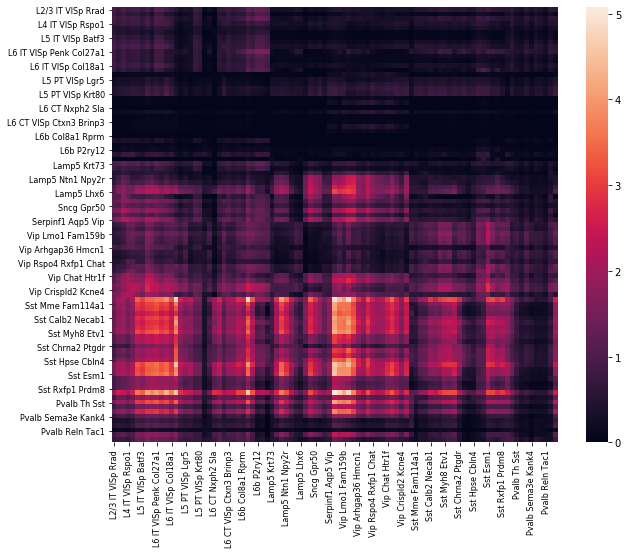

In [30]:
#fig = plt.figure(figsize=(40,25))
fig = plt.figure(figsize=(10,8))

ax = sns.heatmap(data)
ax.tick_params(labelsize=8)
#ax.invert_xaxis()

In [31]:
total_inter[total_inter<1]

array([0.93618726, 0.76848425, 0.95923282, ..., 0.27173913, 0.27042405,
       0.8057656 ])

### Add 1 to everything less than 1

In [32]:
total_inter[total_inter<1] = 1
np.sum(np.sum(total_inter>0, axis=1)) == 93*93

True

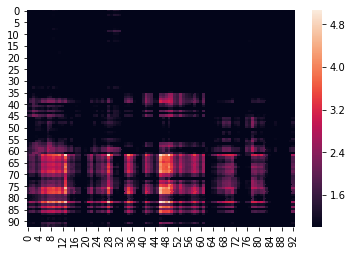

In [33]:
sns.heatmap(total_inter)

### Make it symmetric 

In [34]:
for c in range(93):
    for r in range(93):
        max_val = max(total_inter[c][r], total_inter[r][c])
        total_inter[c][r] = max_val
        total_inter[r][c] = max_val

### Put diagonals to zero 

In [35]:
np.fill_diagonal(total_inter, 0)

### Final graph

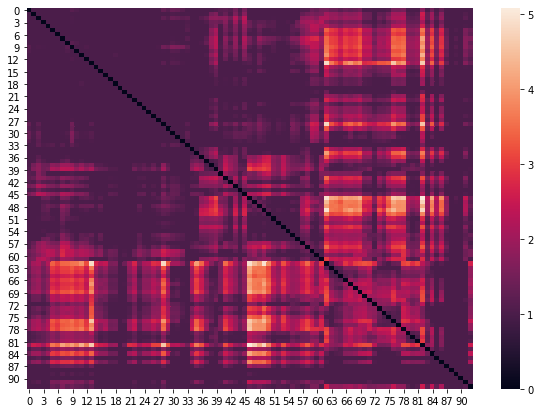

In [36]:
fig = plt.figure(figsize=(10,7))
sns.heatmap(total_inter)

### Put the edges to zero

In [37]:
total_inter = pd.DataFrame(total_inter)
total_inter.head()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.165541,...,1.000000,1.408856,1.000000,1.293914,1.000000,1.0,1.0,1.0,1.000000,1.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.297182,1.970597,1.070450,1.751870,1.000000,1.0,1.0,1.0,1.092622,1.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.002259,1.041684,...,1.309736,2.011988,1.205680,1.872542,1.017171,1.0,1.0,1.0,1.204408,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.017417,...,1.106996,1.614526,1.000000,1.465724,1.000000,1.0,1.0,1.0,1.000000,1.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,1.000000,...,1.348895,2.015004,1.033761,1.759450,1.000000,1.0,1.0,1.0,1.037588,1.0


### Create edge list

Since the index and columns are not all strings ... we need to make both strings before creating the edge list

In [38]:
edge_list = graph_utils.build_edge_list(total_inter, 0, directed=False)

Upper triangle and diag are used as weights


In [39]:
edge_list.source = edge_list.source.apply(str)
edge_list.target = edge_list.target.apply(str)

In [40]:
edge_list

,source,target,weight
0,0,1,1.000000
1,0,2,1.000000
2,0,3,1.000000
3,0,4,1.000000
4,0,5,1.000000
...,...,...,...
4273,89,91,1.000000
4274,89,92,1.017999
4275,90,91,1.000000
4276,90,92,1.000000


### Save the edgelist for future reproducibility

In [69]:
edgelist_dir = utils.get_edgelist_dir(roi= "VISp", 
                                      layer_class= "test_layer", 
                                      project_name= "NPP_GNN_project")
edgelist_filename = "edgelist0.csv"
edge_list.to_csv(edgelist_dir + "/" + edgelist_filename, index=False)

### Read the edgelist

In [48]:
edgelist_dir = utils.get_edgelist_dir(roi= "VISp", 
                                      layer_class= "test_layer", 
                                      project_name= "NPP_GNN_project")
edge_list = pd.read_csv(edgelist_dir + "/" + "edgelist0.csv")
edge_list.source = edge_list.source.apply(str)
edge_list.target = edge_list.target.apply(str)

### Create an "undirected" graph

In [49]:
nxg = graph_utils.build_nx_graph(edge_list, directed=False)
snxg = StellarGraph(nxg)

In [50]:
nxg.nodes

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92'))

In [51]:
snxg.is_directed()

False

## Walk on the graph

In [52]:
layer = "test_layer"
walk_type = "Undirected_Weighted_node2vec"
length = 10
p = 1
q = 1
n = 1

In [53]:
for i in range(0,1):
    rw = BiasedRandomWalk(snxg)
    walks = rw.run(nodes=snxg.nodes(),
               length=length,
               n=n,
               p=p,         # Defines (unormalised) probability, 1/p, of returning to source node
               q=q,         # Defines (unormalised) probability, 1/q, for moving away from source node
               weighted=True)
    filename= "walk" + str(i) + ".csv"

    if not os.path.isfile(walk_dir + "/" + filename):
        utils.write_list_of_lists_to_csv(path=walk_dir, filename=filename, file=[walks[0]])
    else:
        print("The file:", filename, "already exist!")


NameError: name 'walk_dir' is not defined

### Save the walks

In [60]:
walk_dir = utils.get_walk_dir(length= length, 
                              p=p, 
                              q=q, 
                              layer_class=layer, 
                              walk_type= walk_type, 
                              roi="VISp",
                              project_name = "NPP_GNN_project")

In [61]:
walk_dir

'//Users/fahimehb/Documents/NPP_GNN_project/dat/walks/VISp/test_layer/Undirected_Weighted_node2vec/l_10_p_1_q_1'

In [64]:
os.path.isdir(walk_dir)

False

In [65]:
if not os.path.isdir(walk_dir):
    os.mkdir(walk_dir)

In [66]:
filename= "walk0.csv"

if not os.path.isfile(walk_dir + "/" + filename):
    utils.write_list_of_lists_to_csv(path=walk_dir, filename=filename, file=walks)
else:
    print("The file:", filename, "already exist!")

Done writing!


### Read multiple walk files

In [12]:
walks = []
i = 0
for i in range(20):
    for l in [1000]:
        path = (utils.get_walk_dir(
            length=l, 
            p=p, 
            q=q, 
            layer_class=layer, 
            walk_type= walk_type, 
            roi="VISP",
            project_name="NPP_GNN_project"))
        filename = "walk" + str(i) + ".csv"
        tmp = utils.read_list_of_lists_from_csv(path=path, filename=filename)
        walks = walks + tmp
        #print(len(walks))
#         model = Word2Vec(walks,                                
#                     size=size,                                 
#                     sg=sg,                                    
#                     workers=4,                               
#                     min_count=min_count,                            
#                     iter= iter,                               
#                     window=window,                                
#                     compute_loss=True,                       
#                     callbacks=[word2vec_utils.callback(filename=loss_filename, 
#                                         filedir=model_dir)])
#         #plot_utils.plot_loss(loss_filename, model_dir)
#         a = model.wv.vectors
#         b = a.reshape(a.shape[0], 1, a.shape[1])
#         dist = np.sqrt(np.einsum('ijk, ijk->ij', a-b, a-b))
#         dist = pd.DataFrame(dist, index =model.wv.index2word )
#         dist.to_csv(model_dir + "/" + "dist" + str(i) + ".csv", index=model.wv.index2word)
        i += 1

In [13]:
len(walks)

1860

In [192]:
dist = {}
for i in range(20):
    tmp = pd.read_csv(model_dir + "/dist" + str(i) + ".csv", index_col="Unnamed: 0")
    tmp.columns = tmp.index.tolist()
    tmp = tmp.sort_index()[[i for i in range(93)]]
    dist[i] = tmp
    

In [ ]:
fig = plt.figure(figsize=(20,400))

for t in range(93):
    ax = fig.add_subplot(100, 3, t+1)

    for i in range(20):
        if (i==0 or i==4 or i==9 or i==14 or i==19):
            ax.plot(dist[i][t], label=str(i+1))
            ax.legend(loc="lower right")
            ax.set_title("Type:"+ str(t))
plt.show()



In [6]:
walks = utils.read_list_of_lists_from_csv("/Users/fahimehb/Documents/NPP_GNN_project/dat/walks/VISp/test_layer/Undirected_Weighted_node2vec/l_1000000_p_1_q_1/", "walk_0.csv")


In [8]:
len(walks)

1

## Train the model

In [35]:
size = 10
sg = 0
min_count = 0
iter = 1000
window = 2
alpha = 0.001
length = 1000000
p = 1
q = 1
layer = "test_layer"
walk_type = "Undirected_Weighted_node2vec"


model_dir = utils.get_model_dir(
    length= length, 
    p=p, 
    q=q, 
    layer_class=layer, 
    walk_type= walk_type, 
    roi="VISP",
    project_name = "NPP_GNN_project"
)

loss_filename = utils.get_loss_filename(
    size= size, 
    sg=sg, 
    iter=iter, 
    window=window,
    min_count= min_count
)

if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
    
if os.path.isfile(model_dir + "/" + loss_filename):
    os.remove(model_dir + "/" + loss_filename)
    
random.shuffle(walks)

print(loss_filename)

model = Word2Vec(
    walks,         
    size=size,      
    sg=sg,          
    workers=4, 
    min_count=min_count,                            
    iter= iter,                               
    window=window,                                
    compute_loss=True,
    alpha=0.01,
    callbacks=[word2vec_utils.callback(
        filename=loss_filename, 
        filedir=model_dir
    )]
)


size_10_iter_1000_window_2_mincount_0_sg_0.csv


In [36]:
print("Done!")

Done!


### Plot the loss

<module 'matplotlib.pylab' from '/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/matplotlib/pylab.py'>

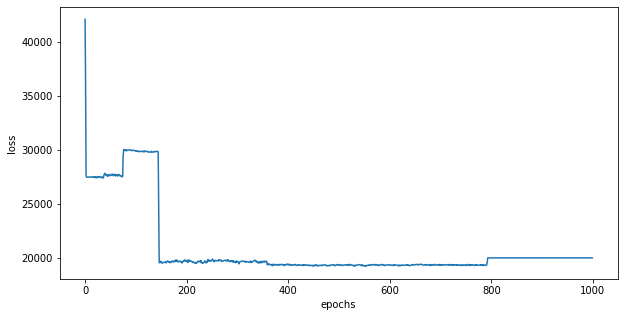

In [37]:
plot_utils.plot_loss(loss_filename, model_dir)
#plt.ylim(0,100000)

In [28]:
from scipy.stats import entropy
def js(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
   # normalize
    p /= p.sum()
    q /= q.sum()
    m = (p + q) / 2
    divergence = (entropy(p, m, base=2) + entropy(q, m, base=2)) / 2
    return np.sqrt(divergence)

In [93]:
from scipy.spatial import distance
import sklearn

dim=3
X = model.wv.vectors
mu = np.mean(X, axis=0)

pca = sklearn.decomposition.PCA()
pca.fit(X)

JSD = []
diff = []
for i in range(dim):
        nComp = dim - i
        Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
        Xhat += mu
    
        tmp1 = word2vec_utils.predict_output_probability(model, X, ["92"])
        tmp1 = [j for (i, j) in tmp1]
        tmp2 = word2vec_utils.predict_output_probability(model, Xhat, ["92"])
        tmp2 = [j for (i, j) in tmp2]
        JSD.append(js(tmp1, tmp2))

/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'number of removed pca components')

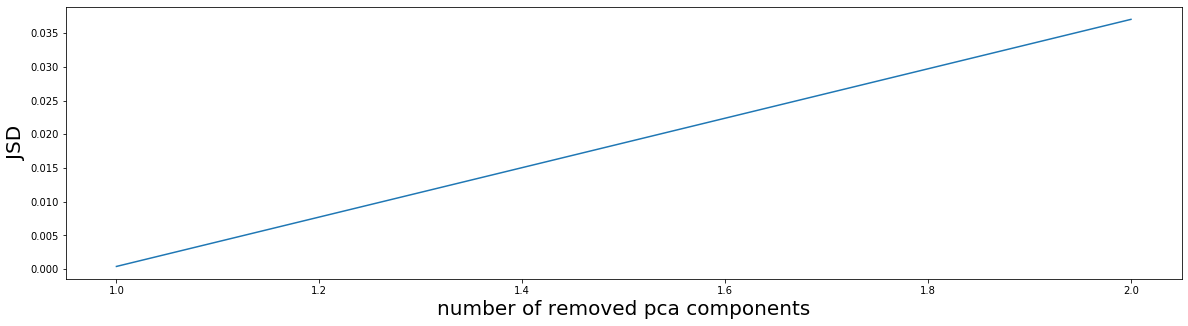

In [94]:
plt.figure(figsize=(20,5))
plt.plot(JSD)
plt.ylabel("JSD", size=20)
plt.xlabel("number of removed pca components", size=20)

In [95]:
JSD

[nan, 0.0003902486806980822, 0.037049403827130775]

In [38]:
data = analysis.summarize_walk_embedding_results(gensim_dict={"model": model.wv.vectors},
                                                 index = model.wv.index2word,
                                                 ndim=model.vector_size, 
                                                 cl_df=cldf)

In [39]:
print(data.shape)
data.head()

(93, 21)


,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,channel_id
cluster_id,,,,,,,,,,,,,,,,,,,,,
82,-0.169631,0.520596,-0.108472,0.681733,-0.396459,-0.606967,0.002677,-0.510599,-0.143967,0.560107,...,Sst Nts,#A81111,#A81111,5,Sst,#F15A29,1,GABAergic,#EF4136,model
62,0.009275,0.677622,-0.046572,0.656549,-0.270450,-0.678686,-0.576696,-0.059195,0.067878,0.028114,...,Sst Chodl,#FFFF00,#FFFF00,5,Sst,#F15A29,1,GABAergic,#EF4136,model
78,-0.098154,0.308142,0.132955,0.550192,0.030798,-0.749292,0.125123,-0.203476,0.033181,-0.007298,...,Sst Esm1,#C11331,#C11331,5,Sst,#F15A29,1,GABAergic,#EF4136,model
76,-0.484671,0.968813,-0.472641,0.421625,-0.278720,-0.523367,-0.132763,-0.396476,-0.282300,0.323767,...,Sst Crhr2 Efemp1,#B95541,#B95541,5,Sst,#F15A29,1,GABAergic,#EF4136,model
69,0.163153,0.325750,0.620918,0.050585,0.370868,-0.039699,-0.636489,-1.145122,-0.090669,0.414526,...,Sst Myh8 Etv1,#D6C300,#D6C300,5,Sst,#F15A29,1,GABAergic,#EF4136,model


### plot emb

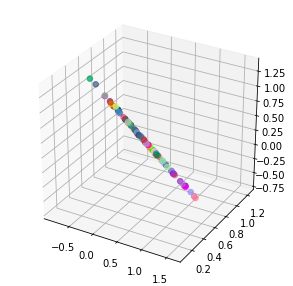

In [19]:
plot_utils.plot_embedding(data=data, cl_df=cldf, plot_dim=3, plot_size=(5,5))

In [40]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(model.wv.vectors)
pca_data = analysis.summarize_walk_embedding_results(gensim_dict={"model": principalComponents},
                                                 index = model.wv.index2word,
                                                 ndim=10, 
                                                 cl_df=cldf)

In [41]:
pca.explained_variance_

array([3.9500377e-01, 3.7985820e-01, 3.4740663e-01, 3.3624256e-01,
       3.1285098e-01, 2.9258382e-01, 2.7539378e-01, 2.6108685e-01,
       2.3934710e-01, 1.8042731e-05], dtype=float32)

In [42]:
pca_data.head()

,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,channel_id
cluster_id,,,,,,,,,,,,,,,,,,,,,
82,-0.492285,-0.564631,0.763684,0.067265,0.362689,-0.316664,-0.314787,-0.162961,-0.065495,-0.005222,...,Sst Nts,#A81111,#A81111,5,Sst,#F15A29,1,GABAergic,#EF4136,model
62,0.096034,-0.642450,0.393098,0.087700,0.098753,-0.563618,-0.399841,0.174828,-0.521060,0.000815,...,Sst Chodl,#FFFF00,#FFFF00,5,Sst,#F15A29,1,GABAergic,#EF4136,model
78,-0.416057,-0.288473,0.208622,0.189717,-0.235915,-0.300707,-0.298056,-0.130812,-0.227440,-0.007484,...,Sst Esm1,#C11331,#C11331,5,Sst,#F15A29,1,GABAergic,#EF4136,model
76,-0.122103,-0.464015,1.058694,-0.469799,0.130318,-0.393030,-0.242289,-0.216531,-0.257943,-0.000910,...,Sst Crhr2 Efemp1,#B95541,#B95541,5,Sst,#F15A29,1,GABAergic,#EF4136,model
69,-0.315811,-0.507931,-0.224922,-0.050616,0.823742,0.136132,0.726308,-0.336018,-0.583012,-0.004199,...,Sst Myh8 Etv1,#D6C300,#D6C300,5,Sst,#F15A29,1,GABAergic,#EF4136,model


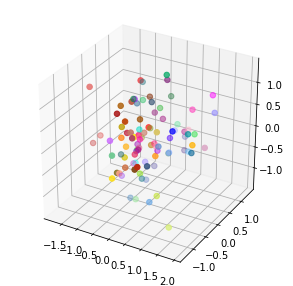

In [43]:
plot_utils.plot_embedding(data=pca_data, cl_df=cldf, plot_dim=3, plot_size=(5,5))

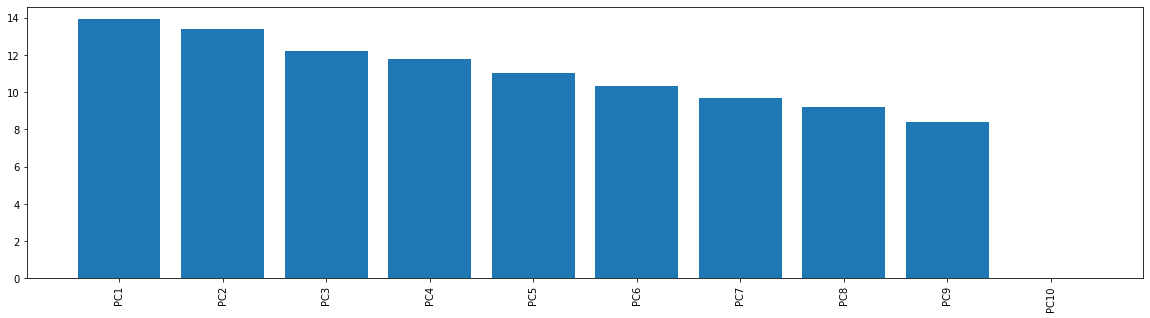

In [45]:
pca = PCA(n_components=10)
pca.fit(model.wv.vectors)
pca_data = pca.transform(model.wv.vectors)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(20,5))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label= labels)
plt.xticks(rotation = 90)
plt.show()

In [107]:
[Y,eigvals] = graph_utils.cmdscale(total_inter)

In [108]:
Y = analysis.summarize_walk_embedding_results(gensim_dict={"model": Y},
                                                 index = [str(i) for i in total_inter.index.tolist()],
                                                 ndim=Y.shape[1], 
                                                 cl_df=cldf)

In [109]:
Y.head()

,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,...,cluster_label,colors,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,channel_id
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.059465,-0.136276,0.060209,-0.165537,0.002957,-0.130337,0.170095,0.035859,-0.015391,0.219320,...,L2/3 IT VISp Rrad,#D9F077,#D9F077,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,model
1,-0.236058,-0.075021,0.183847,-0.227286,-0.053243,-0.126679,-0.039907,0.015445,-0.001889,0.231332,...,L2/3 IT VISp Adamts2,#A6E6A9,#A6E6A9,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,model
2,-0.288396,-0.106112,0.324575,-0.614800,-0.193457,-0.149300,0.374695,0.098872,0.078916,0.542397,...,L2/3 IT VISp Agmat,#7AE6AB,#7AE6AB,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,model
3,-0.022310,0.083506,0.546280,-0.651065,-0.218402,-0.064717,0.462338,0.084070,-0.140027,0.266379,...,L4 IT VISp Rspo1,#00979D,#00979D,8,L4,#00979D,2,Glutamatergic,#27AAE1,model
4,-0.230763,0.164961,0.613962,-0.389010,-0.080473,-0.011980,0.295632,-0.157472,-0.117477,0.023892,...,L5 IT VISp Hsd11b1 Endou,#00DDC5,#00DDC5,9,L5 IT,#008A61,2,Glutamatergic,#27AAE1,model


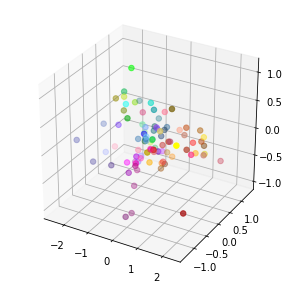

In [110]:
plot_utils.plot_embedding(data=Y, plot_dim=3, cl_df=cldf, plot_size=(5,5))

### CMD scale and procustes

In [111]:
Y_plot = Y.reindex(pca_data.index)
Y_plot = Y_plot[["Z0", "Z1", "Z2"]]
pca_plot = pca_data[["Z0", "Z1", "Z2"]]
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(pca_plot,Y_plot)
print(disparity)

0.5154998786267688


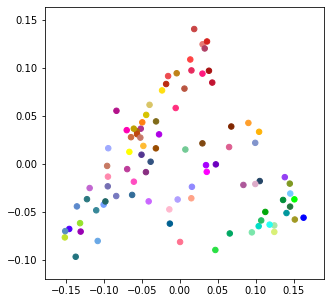

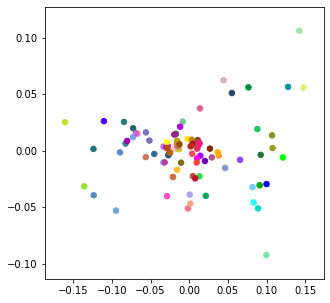

In [112]:
for m in [mtx1, mtx2]:
    m = pd.DataFrame(m, index=Y.index)
    m.index.name = "cluster_id"
    fig = plt.figure(figsize=(5,5))
    df = m.merge(cldf, on= "cluster_id")
    ax = fig.add_subplot(111)
    ax.scatter(df[0], df[1], c=df['cluster_color'], s=30)
    plt.show()

### Umap

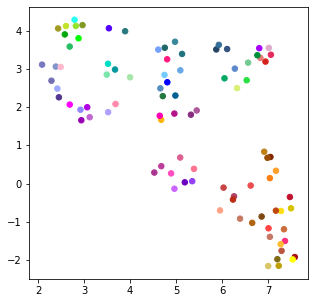

In [258]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(model.wv.vectors)
umap_data = analysis.summarize_walk_embedding_results(gensim_dict={"model": embedding},
                                                 index = model.wv.index2word,
                                                 ndim=embedding.shape[1], 
                                                 cl_df=cldf)
plot_utils.plot_embedding(data=umap_data, plot_dim=2, cl_df=cldf, plot_size=(5,5))

### Predicting the input data

In [509]:
X_rw = pca_data[["Z0", "Z1", "Z2"]]

X_CMD = Y[[col for col in Y.columns if 'Z' in col]]
X_rw = X_rw.reindex(X_CMD.index)

    
y = total_inter

In [511]:
RMSE_rw_list = []
RMSE_CMD_list = []
test_types_list = []

for rs in range(1, 100):
    y_test_rw, y_predict_rw, RMSE_rw = math_utils.Linear_regression_model(X_rw, 
                                                                          y, 
                                                                          1, 
                                                                          randint(0, 10^6))
    y_test_CMD, y_predict_CMD, RMSE_CMD = math_utils.Linear_regression_model(X_CMD, 
                                                                             y, 
                                                                             1, 
                                                                             randint(0, 10^6))
    RMSE_rw_list.append(RMSE_rw)
    RMSE_CMD_list.append(RMSE_CMD)
    test_types_list.append(y_test_rw.index.tolist()[0])


In [512]:
rw_data = pd.DataFrame({"x": [i for i in range(len(RMSE_rw_list))], "y": RMSE_rw_list})
CMD_data = pd.DataFrame({"x": [i for i in range(len(RMSE_CMD_list))], "y": RMSE_CMD_list})
data = {"rw_data":rw_data, "CMD_data":CMD_data}
data_colors = {"rw_data":'b', "CMD_data":'r'}
legends = {"rw_data":'Random_walk', "CMD_data":'CMD_scale'}

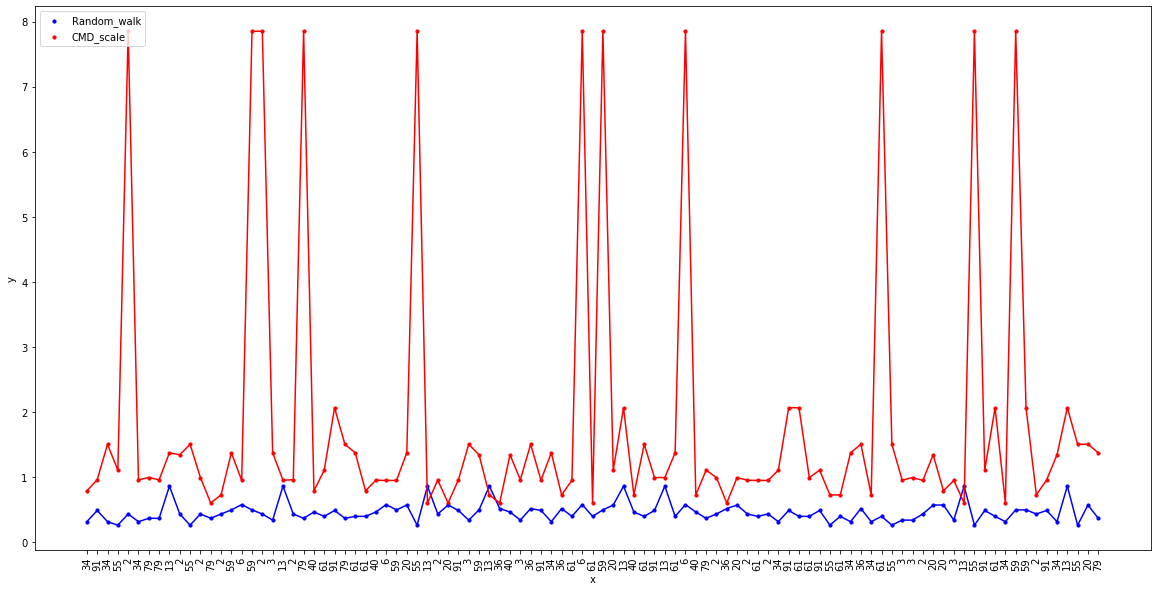

In [513]:
fig = plot_utils.Scatter_plot(datasets= data, 
             datasets_legends=legends, 
             datasets_colors= data_colors, 
             figsize = (20,10), 
             xticks = [i for i in range(len(RMSE_rw_list))], 
             xtick_labels = test_types_list, 
             xtick_label_rotation = 90)

This test probably is meaningless!

In [14]:
def get_most_similar_nodes(model, node, cl_df):
    most_similar = model.wv.most_similar(positive=node)
    idx = cl_df[cl_df.index==node].index.tolist()[0]
    print("most similar nodes to:", cl_df.iloc[idx]['cluster_label'])
    print("______________________")
    
    for t in most_similar:
        idx = cl_df[cl_df.cluster_id==str(t[0])].index.tolist()[0]
        print("(", t[0], ")", cl_df.iloc[idx]['cluster_label'],":", t[1])

In [87]:
def get_closest_nodes(model, ndim, node, cl_df):
    data = analysis.summarize_walk_embedding_results(gensim_dict={"model": model}, 
                                                     ndim=ndim, 
                                                     cl_df=cl_df)
    
    target_idx = node
    print("Closet nodes to", data.loc[target_idx]["cluster_label"])
    print(" ")
    df = pd.DataFrame(columns=["cluster_id", "cluster_label", "dist"])
    for idx in model.wv.index2word:
        dist = np.sqrt(sum(pow(data.loc[target_idx][["Z0", "Z1", "Z2"]] - 
                               data.loc[idx][["Z0", "Z1", "Z2"]], 2)))

        df = df.append({"cluster_id": idx,
                   "cluster_label": data.loc[idx]['cluster_label'], 
                   "dist": dist}, ignore_index=True)
    return df.sort_values(by="dist")[0:10]
